## SOLUTION: ODE challenge 1

In [1]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC

First read in data:

In [2]:
data = pd.read_csv("anna_ode_challenge_1_data.csv")

t_data = data["timestamp"]
x_data = data["value"]

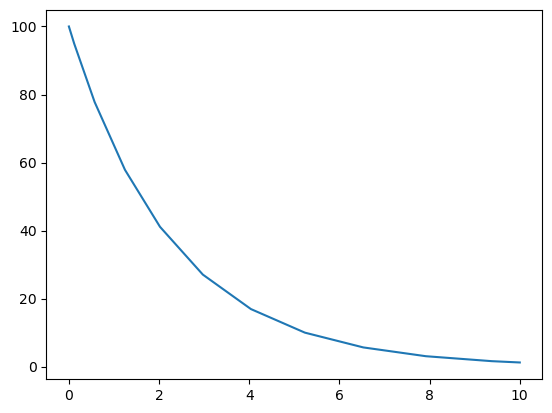

In [3]:
plt.plot(t_data,x_data)
plt.show()

### Solution method: Parameter sweep using scipy's ODEint

To solve this problem, we can sweep over different values of $\varepsilon$, using our model to produce results for each one. Then we'll compare these results to the true data and see which one reproduces the original data the closest.

In [4]:
def diffyqs(X, t, a): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    y = X
    dydt = -a*y
    return dydt

In [5]:
# initial conditions (could get these from data)
x0_1 = [x_data[0]]

# use time data as time array for solver
t = t_data


### "by hand" solution

In [6]:
def log_likelihood(theta):
    a = theta
    sol = odeint(diffyqs, x0_1, t, args=(a,))
    return -np.sum((sol.T[0] - x_data)**2) ## FROM GAUSSIAN

sols = []
for i in np.arange(0,1,0.01):
    sols.append(log_likelihood(i))
print("best choice for a:",np.arange(0,1,0.01)[np.argmax(np.array(sols))])
plt.plot(sols)
plt.show()

KeyboardInterrupt: 

## Solution with PyVBMC

In [ ]:
D = 1  

LB = np.full((1, D), 0)  # Lower bounds 
UB = np.full((1, D), 10)  # Upper bounds 

PLB = np.copy(LB)
PUB = np.copy(UB) 
PUB[0][0] = 1
PLB[0][0] = 0.1

x0 = 3 * np.ones((1, D))

In [ ]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Casting lower bounds to floating point.
Casting upper bounds to floating point.
Casting plausible lower bounds to floating point.
Casting plausible upper bounds to floating point.
vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
vbmc:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds PLB and PUB. Expanding the plausible bounds...
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10         114.19        51.50 253028167525316001792.00        2        inf     start warm-up
     1         15          -6.90         0.00        10.62        2        inf     
     2         20          -6.89         0.00         0.01        2      0.408     
     3         25          -6.89         0.00         0.01        2      0.468     
     4         30          -6.88         0.00         0.00        2     0.0381     
     5         35          -6.88         0.00         0.00        2     0.0257     
     6         40          -6.90         0.00         0.00        2     0.0885     end warm-up
     7         45          -6.89         0.00         0.01        2      0.401     
     8         50          -6.89         0.00         0.00        2      0.116     
     9         55          -6.91         0.00         0.02        5       0.59     
    10         60          -7.19         0.00         0.24        5       8.86     
    11         65          -6.92        

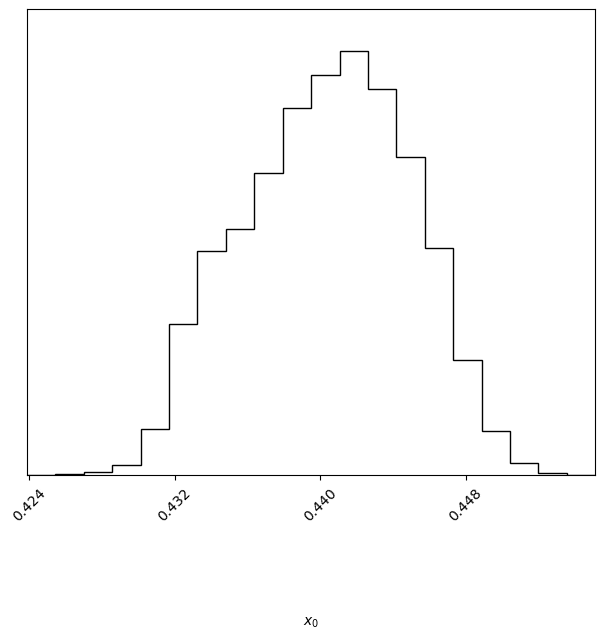

In [ ]:
vp.plot();

The approximate value of a: [0.44026417]


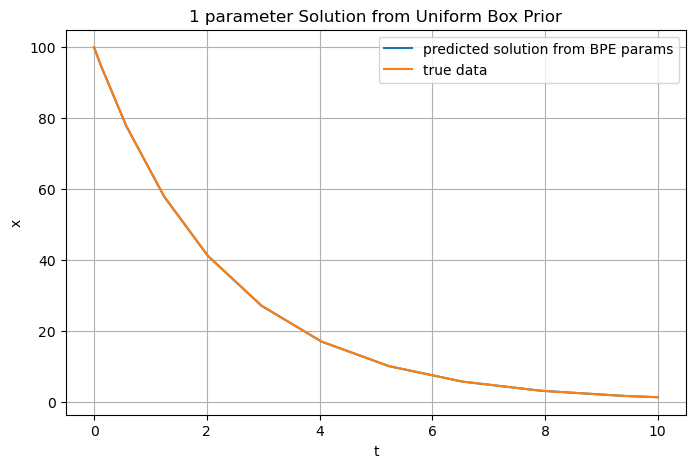

In [ ]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate value of a:", post_mean)


a =  post_mean[0]

sol = odeint(diffyqs, x0_1, t, args=(a,))

plt.figure(figsize=(8,5))
plt.title("1 parameter Solution from Uniform Box Prior")
plt.plot(t,sol.T[0], label = "predicted solution from BPE params")
plt.plot(t,x_data, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

In [ ]:
def diffyqs(X, t, a, b): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    y = X
    dydt = -(a + b)*y
    return dydt

# initial conditions (could get these from data)
x0_1 = [x_data[0]]

# use time data as time array for solver
t = t_data

def log_likelihood(theta):
    a,b = theta
    sol = odeint(diffyqs, x0_1, t, args=(a,b))
    return -np.sum((sol.T[0] - x_data)**2) ## FROM GAUSSIAN

D = 2

LB = np.full((1, D), 0)  # Lower bounds 
UB = np.full((1, D), 1000)  # Upper bounds 

PLB = np.copy(LB)
PUB = np.copy(UB) 
PUB[0][0] = 10
PLB[0][0] = 0.1

PUB[0][1] = 10
PLB[0][1] = 0.1

x0 = 3 * np.ones((1, D))

In [ ]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize(); # do optimization (might take a while)

Casting lower bounds to floating point.
Casting upper bounds to floating point.
Casting plausible lower bounds to floating point.
Casting plausible upper bounds to floating point.
vbmc:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action


     0         10       -6835.97       939.58  98011030.34        2        inf     start warm-up
     1         15         -22.06         0.30     15603.41        2        inf     
     2         20         -22.29         0.59        13.57        2        323     
     3         25         -22.29         0.00         0.07        2       1.67     
     4         30         -22.31         0.00         0.00        2      0.175     
     5         35         -22.29         0.00         0.00        2      0.131     
     6         40         -22.31         0.00         0.00        2      0.175     end warm-up
     7         45         -22.29         0.00         0.01        2      0.251     
     8         50         -22.31         0.00         0.00        2     0.0675     
     9         55         -21.73         0.00         0.16        5       5.59     
    10         60         -21.47         0.00         0.18        6       5.03     
    11         65         -21.44         0.00       

KeyboardInterrupt: 

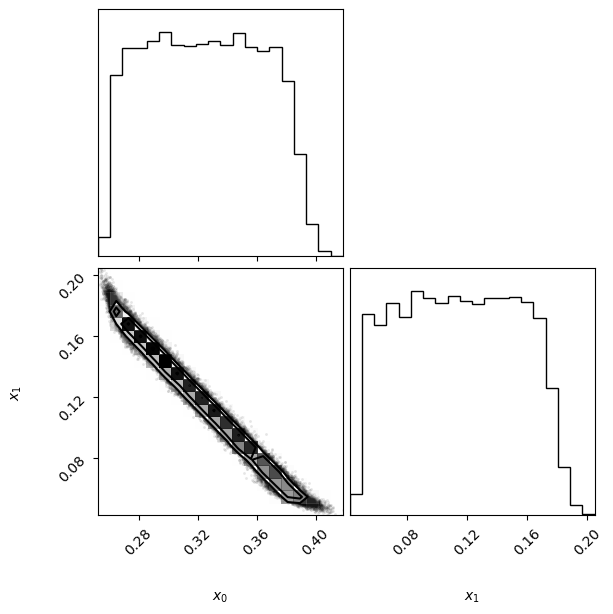

In [ ]:
vp.plot();

The approximate value of a: [0.32510616 0.11527652]


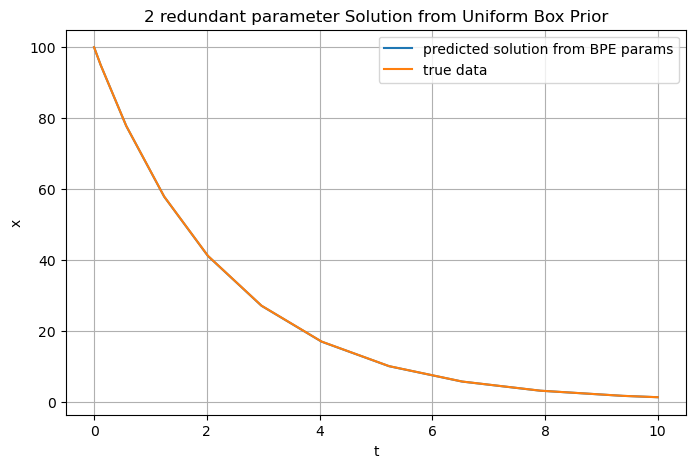

In [ ]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate value of a:", post_mean)


a =  post_mean[0]
b =  post_mean[1]

sol = odeint(diffyqs, x0_1, t, args=(a,b))

plt.figure(figsize=(8,5))
plt.title("2 redundant parameter Solution from Uniform Box Prior")
plt.plot(t,sol.T[0], label = "predicted solution from BPE params")
plt.plot(t,x_data, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

In [ ]:

def CI_1D(pdf,true_value,step):
    a,b = pdf_mode - step, pdf_mode + step
    I = 0
    def check_if_in_CI(true_value,a,b):
        if a <= true_value and true_value <= b:
            return False
        else:
            return True
    while check_if_in_CI(true_value,a,b):
        I = integrate(pdf,a,b)
        a -= step
        b += step
    return I

In [ ]:
vp.pdf(np.array([[0]]))
simple_pdf = lambda x: vp.pdf(np.array([[x]]))
I0 = integrate.quad(vp.pdf,0,3)
I1 = integrate.quad(simple_pdf,0,1)

print(I0[0],I1[0])

1.000000000000008 1.000000000000008


In [ ]:
x_range = np.arange(-5,5,0.01)
y = np.array([simple_pdf(x) for x in x_range])
x_range[np.argmax(y)]

0.43999999999988404

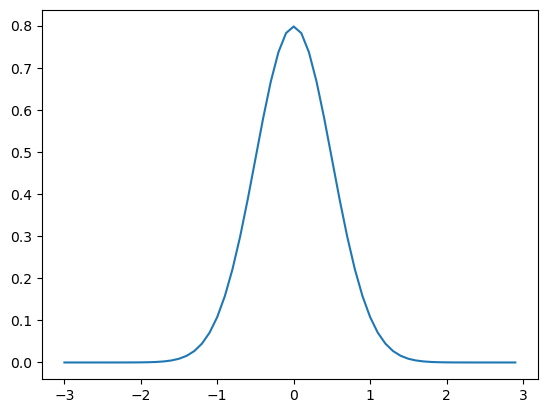

In [7]:
norm = scs.norm(loc = 0, scale = 0.5)

plt.plot(np.arange(-3,3,0.1),norm.pdf(np.arange(-3,3,0.1)))



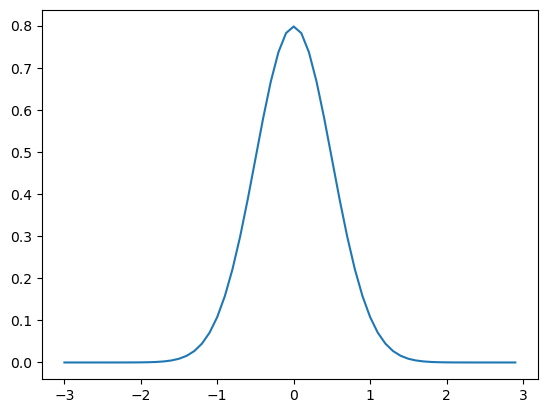

1 std CI: 0.9566166124647066


In [10]:
import scipy.stats as scs
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

sigma = 0.5
norm = scs.norm(loc = 0, scale = sigma)
plt.plot(np.arange(-3,3,0.1),norm.pdf(np.arange(-3,3,0.1)))
plt.show()

def CI_1D(pdf,true_value,step = 0.05,x_lb = -10,x_ub = 10):
    x_range = np.arange(x_lb,x_ub,step)
    y = np.array([pdf(x) for x in x_range])
    pdf_mode = x_range[np.argmax(y)]
    a,b = pdf_mode - step, pdf_mode + step
    I = 0
    def check_if_in_CI(true_value,a,b):
        if a <= true_value and true_value <= b:
            return False
        else:
            return True
    while check_if_in_CI(true_value,a,b):
        
        a -= step
        b += step
    I = integrate.quad(pdf, a, b)[0]
    return I

print("1 std CI:",CI_1D(norm.pdf,1,0.01))

# TODO: make fast version that uses knowledge of truth to not have to iterate

# example of how you could use it with PyVBMC
#simple_pdf = lambda x: vp.pdf(np.array([[x]]))
#CI_1D(simple_pdf,0.44,0.1)

In [ ]:
# example of how you could use it with PyVBMC
#simple_pdf = lambda x: vp.pdf(np.array([[x]]))
CI_1D(vp.pdf,0.44,0.1)

0

In [ ]:
sigma = 0.5
cov = np.array([[sigma,0],[0,sigma]])
norm = scs.multivariate_normal(cov = cov)


def CI_2D(vp,pdf,true_value,step = 0.05,x_lb = -10,x_ub = 10,n_samples = int(5e5)):
    # do sampling, take mode of samples
    Xs, _ = vp.sample(n_samples) # sample vp
    pdf_mode = scs.mode(Xs)
    a,b = pdf_mode - step, pdf_mode + step
    I = 0
    def check_if_in_CI(true_value,a,b):
        if a <= true_value[0] and true_value[0] <= b \
            and a <= true_value[1] and true_value[1] <= b:
            return False
        else:
            return True
    while check_if_in_CI(true_value,a,b):
        I = integrate.dblquad(pdf, a, b, a, b)[0]
        a -= step
        b += step
    return I

print("1 std CI:$",CI_2D(vp,norm.pdf,[0.5,0.5],0.01))

C:\Users\walki\AppData\Local\Temp\ipykernel_1248\409915409.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  pdf_mode = scs.mode(Xs)


TypeError: unsupported operand type(s) for -: 'ModeResult' and 'float'

In [ ]:
norm.pdf([0,3])

3.928256069279485e-05